# Supplementary Figure 5: Bortezomib in unfolded protein response

In Supplementary Figure 5, we highlight differential expression of genes in Unfolded Protein Response (UPR) pathways. This gene set is curated from the Reactome gene set for UPR, and grouped based on the review by Rutkowski and Kaufman:

Rutkowski, D. T. & Kaufman, R. J. That which does not kill me makes me stronger: adapting to chronic ER stress. Trends Biochem. Sci. 32, 469–476 (2007)

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(cowplot)

In [2]:
out_dir <- "output/supp_figure_5"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the analysis results for MAST DEG tests, and will then filter those results for bortezomib conditions.

In [3]:
deg_uuid <- list("fc83b89f-fd26-43b8-ac91-29c539703a45")

In [4]:
deg_fres <- cacheFiles(deg_uuid)
deg_file <- list.files(
    paste0("cache/",deg_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



In [5]:
all_deg <- read.csv(deg_file)

In [6]:
all_deg <- all_deg %>%
  mutate(
      direction_sign = ifelse(
          is.na(logFC),
          sign(coef_D),
          sign(logFC)
      ),
      direction = ifelse(
          direction_sign == 1,
          "up", "dn"
      )
  )

Since there aren't significant DEGs for 4 hr Bortezomib treatment, we'll retain only 24 and 72 hour results for plotting.

In [7]:
deg <- all_deg %>%
  filter(fg == "bortezomib",
         timepoint %in% c(24, 72))

In [8]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

## UPR heatmap

In [9]:
upr_genes <- read.csv("../common/gene_sets/upr_genes.csv")

For this plot, we'll retain only the UPR genes that are differentially expressed in at least one comparison. We'll also want to retain major regulators regardless of differential expression for context.

In [10]:
sig_upr_deg <- deg %>%
  filter(gene %in% upr_genes$gene) %>%
  filter(adjP < 0.01)

In [11]:
upr_genes <- upr_genes %>%
  filter(gene %in% sig_upr_deg$gene | upr_pathway == "Key regulators") %>%
  mutate(order = n():1) %>%
  mutate(gene_ypos = order + y_offset)

In [12]:
nrow(upr_genes)

[1] 56

In [13]:
plot_deg <- deg %>%
  filter(gene %in% upr_genes$gene) %>%
  left_join(upr_genes, by = c("gene" = "gene"))

In [14]:
max_val <- 1.2

type_pos <- type_colors %>%
  filter(aifi_cell_type %in% plot_deg$aifi_cell_type) %>%
  arrange(cell_type_xpos) %>%
  mutate(cell_type_xpos = 1:n())

type_plot_deg <- plot_deg %>%
  mutate(treat_label = "Bor/DMSO") %>%
  rename(aifi_cell_type = aifi_cell_type) %>%
  left_join(type_pos) %>%
  mutate(logFC = ifelse(
      abs(logFC) > max_val | is.na(logFC),
      max_val * direction_sign,
      logFC
  ))

sig_plot_deg <- type_plot_deg %>%
  filter(adjP < 0.01)

h_guides <- data.frame(
    y = setdiff(1:max(upr_genes$gene_ypos), upr_genes$gene_ypos)
)

Joining with `by = join_by(aifi_cell_type)`


In [15]:
out_data <- file.path(out_dir, paste0("bortezomib_upr_data_", Sys.Date(), ".csv"))

write.csv(
    type_plot_deg,
    out_data,
    quote = FALSE, row.names = FALSE
)

In [16]:
head(type_plot_deg)

,aifi_cell_type,timepoint,fg,bg,n_sample,gene,coef_C,coef_D,logFC,nomP,⋯,alt_name,y_offset,y_pos,order,gene_ypos,treat_label,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,t_cd4_cm,24,bortezomib,dmso,648,ACADVL,0.10974507,1.17030410,0.16816106,1.268284e-11,⋯,,0,50,27,27,Bor/DMSO,CD4 CM,#00AEEF,2,6
2,t_cd4_cm,24,bortezomib,dmso,648,ADD1,-0.01612753,0.31371079,0.09959141,2.549561e-02,⋯,,0,49,26,26,Bor/DMSO,CD4 CM,#00AEEF,2,6
3,t_cd4_cm,24,bortezomib,dmso,648,ATF4,0.03578264,0.02971956,0.01806443,3.894864e-01,⋯,,2,62,35,37,Bor/DMSO,CD4 CM,#00AEEF,2,6
4,t_cd4_cm,24,bortezomib,dmso,648,ATF6,0.07217600,0.31740758,0.15760344,1.316519e-03,⋯,,4,94,56,60,Bor/DMSO,CD4 CM,#00AEEF,2,6
5,t_cd4_cm,24,bortezomib,dmso,648,ATP6V0D1,-0.06389532,-0.10177899,-0.01555072,2.707261e-01,⋯,,0,47,24,24,Bor/DMSO,CD4 CM,#00AEEF,2,6
6,t_cd4_cm,24,bortezomib,dmso,648,CALR,-0.02492160,-0.13081358,-0.04264441,3.958763e-01,⋯,,1,56,30,31,Bor/DMSO,CD4 CM,#00AEEF,2,6


In [17]:
all_pos <- expand.grid(
    gene_ypos = upr_genes$gene_ypos,
    cell_type_xpos = type_pos$cell_type_xpos,
    timepoint = c(24, 72)
)
missing_pos <- all_pos %>%
  filter(!paste(gene_ypos, cell_type_xpos, timepoint) %in% 
          paste(type_plot_deg$gene_ypos, type_plot_deg$cell_type_xpos, type_plot_deg$timepoint))

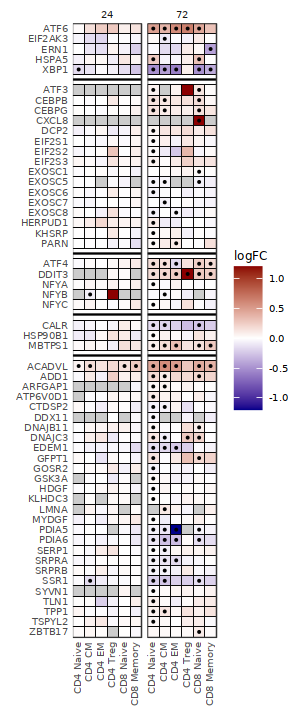

In [18]:
options(repr.plot.width = 2.5, repr.plot.height = 6)

upr_plot <- ggplot() +
  geom_hline(data = h_guides,
             aes(yintercept = y)) +
  geom_rect(
      data = type_plot_deg,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5,
          fill = logFC),
      color = "black",
      linewidth = 0.2
  ) +
  geom_rect(
      data = missing_pos,
      aes(xmin = cell_type_xpos - 0.5, xmax = cell_type_xpos + 0.5,
          ymin = gene_ypos - 0.5,
          ymax = gene_ypos + 0.5),
      fill = "gray80",
      color = "black",
      linewidth = 0.2
  ) +  
  geom_point(
      data = sig_plot_deg,
      aes(x = cell_type_xpos,
          y = gene_ypos),
      color = "black",
      shape = 16,
      size = 0.5
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      limits = c(-max_val, max_val)
  ) +
  scale_y_continuous(
      "",
      breaks = upr_genes$gene_ypos,
      labels = upr_genes$gene,
      expand = c(0,0)
  ) +
  scale_x_continuous(
      "",
      limits = c(0.5,6.5),
      breaks = type_pos$cell_type_xpos,
      labels = type_pos$cell_type_label,
      expand = c(0,0)
  ) +
  facet_grid(
      cols = vars(timepoint)
  ) + 
  theme_bw(base_size = 7) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank())

upr_plot

In [19]:
out_plot <- file.path(out_dir, paste0("bortezomib_upr_heatmap_", Sys.Date(), ".pdf"))

ggsave(
    out_plot,
    upr_plot,
    width = 2.5, height = 6
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [20]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Supp Fig 5", Sys.Date())

In [21]:
out_list <- as.list(c(out_data, out_plot))

In [22]:
out_list

[[1]]
[1] "output/supp_figure_5/bortezomib_upr_data_2023-10-27.csv"

[[2]]
[1] "output/supp_figure_5/bortezomib_upr_heatmap_2023-10-27.pdf"

In [23]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = deg_uuid,
    store = "project",
    doPrompt = FALSE
)

ERROR: Error: Request to https://allenimmunology.org/tracer/trace failed. Status: 400 Bad Request, Message: "Invalid trace title: Title \"VRd TEA-seq Supp Fig 5 2023-10-27\" is not unique"


In [ ]:
sessionInfo()